<a href="https://colab.research.google.com/github/bearylogical/nn_tensiometry/blob/master/notebooks/02_ForwardProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the forward problem using PiNNs

## Load Libraries

In [2]:
!pip install deepxde

     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 860kB 17.4MB/s 
  Created wheel for salib: filename=SALib-1.3.13-py2.py3-none-any.whl size=729580 sha256=e539252b14da7bb672e361319d66c1f603361bf7905999726174921a759d6e79
  Stored in directory: /root/.cache/pip/wheels/d7/c3/9b/c5219d4848c1c4d308b41672c0a8c5f2a95c94ed000d6bb5d9
Successfully built salib


In [1]:
import deepxde as ddea
from deepxde.backend import tf
import numpy as np
from deepxde.callbacks import EarlyStopping
import matplotlib.pyplot as plt

SyntaxError: ignored

## Pendant Drop Equations

We use the young laplace formula and solve for the curvatures

$
\begin{align}
& \sigma(\kappa_s+\kappa_\psi) = p_L - \Delta \rho g z \\
\kappa_s = \frac{\text{d}\psi}{\text{d}{s}} = -\frac{\frac{d^2r}{ds^2}}{\sqrt{1-(dr/ds)^2}}\hspace{1em} & \kappa_{\phi} = \frac{\text{sin}(\psi)}{r}  = \frac{1}{r}\frac{dz}{ds}\hspace{1em} & \psi = \text{tan}^{-1} \left( \frac{dz}{dr} \right) \\
\end{align}
$

With the following boundary conditions
$\begin{align} @s=0, z=0, r=0, \psi = 0  ;  @s=L, r=r_{needle};   \end{align} $



## Constants

In [ ]:
sigma = 72.0;        # surface tension [mN/m]
grav = 1.0;     # gravitational acceleration [mm/s^2]
rneedle = 1.0;       # radius of the needle [mm]
deltarho = 1.0;   # density difference [10^6 kg/m^3]
p_l = 70.2799663375; # laplace pressure
s = 1.9893

In [ ]:
# convention, r = 0 , z=1
def pde(x,y):
    
    r = y[:,0:1]
    z = y[:,1:2]
    
    dr_ds = dde.grad.jacobian(r, x)
    dr_dss = dde.grad.hessian(r, x)
    
    dz_ds = dde.grad.jacobian(z, x)
    dz_dss = dde.grad.hessian(z, x)
    
    kappa_s = - tf.math.divide_no_nan(dr_dss, tf.math.sqrt(1.0-tf.math.square(dr_ds)))
    kappa_phi = tf.math.divide_no_nan(1.0,r) * dz_ds
    eqn_1 = dr_ds - 1/s * tf.math.cos(phi)
    eqn_2 = dz_ds - 1/s * tf.math.sin(phi)
    eqn_3 = p_l - z - sigma(s * kappa_s + kappa_phi) 
    
    psi = tf.math.atan2(dz_ds, dr_ds)
    
    lhs = sigma * (kappa_s + kappa_phi)
    rhs = tf.constant(p_l) - tf.constant(deltarho * grav) * z
    
    return [eqn_1, eqn_2, eqn_3]

def func(inputs, outputs, X):
    r = outputs[:,0:1]
    z = outputs[:,1:2]
    # Compute theta from X using numpy or tensorflow. You need to be careful here
    dr_ds = dde.grad.jacobian(r, inputs)
    dz_ds = dde.grad.jacobian(z, inputs)
    # Compute dphi/dx as you do for the PDE
    return tf.math.atan2(dz_ds,dr_ds) 

geom = dde.geometry.Interval(0, 1)

def bot_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def top_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bot_bc_r = dde.DirichletBC(geom, lambda x: 0, bot_boundary, component = 0)  # r(0) = 0
bot_bc_z = dde.DirichletBC(geom, lambda x: 0, bot_boundary, component = 1) # z(0) = 0
top_bc_r = dde.DirichletBC(geom, lambda x: rneedle, top_boundary, component=0) # r(L) = r_needle
apex_bc = dde.OperatorBC(geom, func, bot_boundary)


data = dde.data.PDE(
    geom,
    pde,
    [bot_bc_r,bot_bc_z,top_bc_r,apex_bc],
    num_domain=1000,
    num_boundary=50,
    num_test=3000
)

layer_size = [1] + [30] * 2 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer, regularization='l1')
# net.apply_output_transform(lambda x, y: y*2)

model = dde.Model(data, net)

model.compile("adam", lr=0.001,loss_weights = [1e-3, 1, 1 , 1,1])
 
early_stopping = EarlyStopping(min_delta=1e-8, patience=40000)
losshistory, train_state =   model.train(epochs=5000, display_every=1000, callbacks=[early_stopping],
                disregard_previous_best=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.054259 s



/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.938231 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.31e+03, 0.00e+00, 0.00e+00, 6.00e-01, 8.82e-01]    [4.79e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.78e-01, 6.75e-03, 2.14e-04, 2.99e-01, 8.57e-02]    [5.30e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [8.96e-02, 7.21e-03, 4.88e-05, 1.71e-01, 2.27e-02]    [7.89e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [3.67e-02, 7.35e-03, 1.16e-06, 7.85e-02, 1.01e-02]    [3.44e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4000      [2.84e-02, 7.50e-03, 5.88e-07, 2.96e-02, 8.35e-03]    [2.64e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
5000      [2.33e-02, 7.66e-03, 9.21e-07, 9.26e-03, 6.79e-03]    [2.16e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 5000:
  train loss: 4.70e-02
  test loss

In [ ]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()

Text(0, 0.5, 'z')

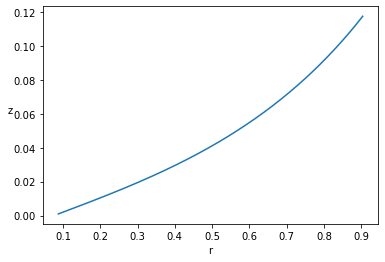

In [ ]:
fig, ax = plt.subplots()
ax.plot(best_y.T[0],best_y.T[1])
ax.set_xlabel('r')
ax.set_ylabel('z', rotation=0)